In [3]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Plan

1. Describe the task
2. Make the simplest visualization you can think of that contains:
    - the Dependent Variable, i.e. the behavior of the participants that you're trying to model/predict/explain/account for/etc
    - the Independent Variable(s), i.e. the features of the trial that you think might influence behavior
    - draw each trial as a point on this graph
3. Think of possible models that would generate similar values for the DV given the observed values for the IV

## 1. Describe the task

Some description here.

## 2. Make a visualization

##### Load some data

In [4]:
data_dir = '/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/Teaching/Computational_modeling_tutorial/Data/Joey'

In [5]:
data = pd.read_csv(data_dir + '/Study1_UG_Data.csv')
data = data[['sub','trial','unfairness','choice']]
data['offer'] = 100 - data['unfairness']
data.head()

,sub,trial,unfairness,choice,offer
0,1,1,50,0,50
1,1,2,80,0,20
2,1,3,95,0,5
3,1,4,60,0,40
4,1,5,75,0,25


##### Make a simple plot

In [6]:
sub = 2
# sub_dat = data.loc[data['sub']==2, :]
sub_data = data.query('sub == 2')
sub_data.head()

,sub,trial,unfairness,choice,offer
20,2,1,60,0,40
21,2,2,55,0,45
22,2,3,85,1,15
23,2,4,95,1,5
24,2,5,65,0,35


##### Plot each trial independently, use transparency to visualize overlap

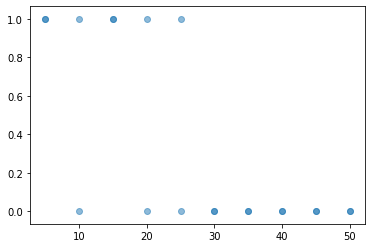

In [7]:
plt.scatter(x = sub_data['offer'], y = sub_data['choice'], alpha = .5)

##### Average over trials with the same offer

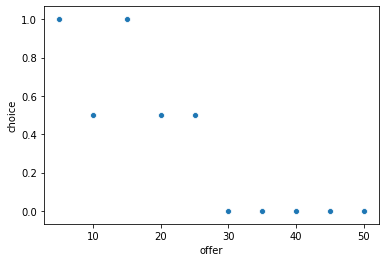

In [8]:
sns.scatterplot(x = 'offer', y = 'choice',
            data = sub_data.groupby(['offer'], as_index = False).mean())

## 3. Think of a model that can recreate this plot

- Model 1: always accept.
- Model 2: always reject.
- Model 3: act randomly.
- Model 4: maximize payoff ('greed').
- Model 5: minimize payoff ('inverse greed').
- Model 6: unfairness punisher (reject with a probability P proportional to the unfairness of the offer).
- Model 7: inequity aversion.

In [140]:
def model_1(params, offer):
    
    choice = 0
    
    return choice

In [141]:
def model_2(params, offer):
    
    choice = 1
    
    return choice

In [142]:
def model_3(params, offer):
    
    choice = np.random.randint(0,2)
    
    return choice

In [143]:
def model_4(params, offer):
    
    choice_options = [0,1]
    payoffs = [offer,0]

    # A quicker way?
    choice_index = np.where(payoffs == np.max(payoffs))[0][0]
    choice = choice_options[choice_index]
    
    return choice

In [144]:
def model_5(params, offer):
    
    # Minimize payoff
    choice_options = [0,1]
    payoffs = [offer,0]
    
    # Find the lowest-value choice option
    choice_index = np.where(payoffs == np.min(payoffs))[0][0]
    choice = choice_options[choice_index]
    
    return choice

In [145]:
def model_6(params, offer):
    
    # Idea: reject proportional to the unfairness
    max_offer = 50
    unfairness = 1 - offer / max_offer
#     unfairness = np.abs(offer, 100 - offer) / 100 # Alternative definition of unfairness
        
    if np.random.rand() < unfairness:
        choice = 1
    else:
        choice = 0
    
    return choice

In [146]:
def model_7(params, offer):
    
    # Inequity aversion model with one inequity term (= symmetric) and a money term
    payoffs = [offer, 0]
    inequities = [(100-offer)-offer, 0]
    utilities = payoffs - np.multiply(params[0],inequities)
    choice = np.where(utilities == np.max(utilities))[0][0]

    return choice

## 4. Simulating task data

In [147]:
data_to_simulate = sub_data[['trial','offer','choice']].copy()
data_to_simulate['choice'] = np.nan
data_to_simulate.head()

,trial,offer,choice
20,1,40,NaN
21,2,45,NaN
22,3,15,NaN
23,4,5,NaN
24,5,35,NaN


In [156]:
def simulate_model(model, data_to_simulate, params = None):
    
    # Input variables: ...asdoaijsoiajc
    
    # Create output dataframe
    simulation_results = data_to_simulate.copy()
    
    # Loop over trials and simulate each trial
    for trial in data_to_simulate['trial']:
        offer = data_to_simulate.loc[data_to_simulate['trial']==trial, 'offer'].values[0]
        predicted_choice = model(params, offer)
        # store in output dataframe:
        simulation_results.loc[data_to_simulate['trial']==trial,'choice'] = predicted_choice
        
    return simulation_results

In [162]:
simulated_sub_data = simulate_model(model_7, data_to_simulate, [.5])

In [163]:
simulated_sub_data.head()

,trial,offer,choice
20,1,40,0.0
21,2,45,0.0
22,3,15,1.0
23,4,5,1.0
24,5,35,0.0


##### Visualize simulation

In [164]:
def plot_simulation(simulated_sub_data):
    
    fig = sns.scatterplot(data = simulated_sub_data, x = 'offer', y = 'choice')
    
    return fig

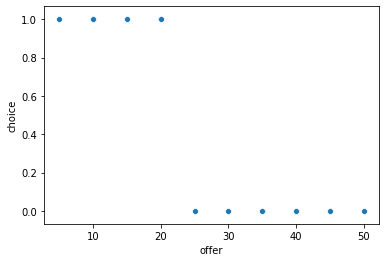

In [165]:
plot_simulation(simulated_sub_data)

So here we have a dataset – basically a list of trials that together constitute an experiment – with simulated task data! We've basically generated a pseudo-subject based on one of the models we defined. In the next steps, we will compare such simulated datasets to our actually observed subject data. The more similar a model's simulation is to observed task data, the better the model 'fits' the data.